### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-1/agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent（智能体）

## 回顾

我们之前构建了一个“路由器”。

- 我们的聊天模型会根据用户输入，决定是否调用某个工具（tool）。
- 我们使用“条件边”（conditional edge）将流程路由到会调用工具的节点，或直接结束。

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## 目标

现在，我们把它扩展为一个通用的智能体架构。

在上面的路由器中，我们先调用模型；如果模型选择调用工具，我们会把工具的输出作为 `ToolMessage` 返回给用户。

但是，如果我们把这个 `ToolMessage` 再“传回给模型”会怎样？

这样模型就可以： (1) 继续调用其他工具；或 (2) 直接给出最终回答。

这正是 [ReAct](https://react-lm.github.io/)（一种通用智能体架构）的直觉：

- `act`：让模型调用特定工具
- `observe`：把工具输出反馈给模型
- `reason`：让模型基于工具输出进行推理，决定下一步（例如继续调用工具或直接回复）

这种[通用架构](https://blog.langchain.dev/planning-for-agents/)可适配多种类型的工具。

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 langgraph-prebuilt==0.6.4

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


这里我们使用 [LangSmith](https://docs.smith.langchain.com/) 做[链路追踪](https://docs.smith.langchain.com/concepts/tracing)。

我们会把运行数据记录到名为 `langchain-academy` 的项目中。

**补充说明：**

要使用 LangSmith，你需要获取 `LANGSMITH_API_KEY`。请按照以下步骤操作：

1.  访问 [LangSmith 网站](https://smith.langchain.com/)。
2.  注册或登录你的账户。
3.  在设置中找到 API Keys 部分，创建并复制你的 API Key。
4.  将复制的 API Key 粘贴到下面的输入框中。

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """将 a 与 b 相乘。

    参数:
        a: 第一个整数
        b: 第二个整数
    """
    return a * b

# 该函数会作为一个工具（tool）暴露给模型
def add(a: int, b: int) -> int:
    """将 a 与 b 相加。

    参数:
        a: 第一个整数
        b: 第二个整数
    """
    return a + b

def divide(a: int, b: int) -> float:
    """用 a 除以 b。

    参数:
        a: 被除数（整数）
        b: 除数（整数）
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# 在本笔记本中将并行工具调用关闭（parallel_tool_calls=False）。
# 原因：数学步骤通常是串行进行；同时此处有 3 个可做数学运算的工具。
# 提示：OpenAI 模型为提高效率默认支持并行工具调用，参考文档：
# https://python.langchain.com/docs/how_to/tool_calling_parallel/
# 你可以尝试打开并行看看模型在数学场景下的表现差异。
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

接下来创建我们的 LLM，并通过提示词（system prompt）明确本智能体的整体行为目标。

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# 系统消息：设定智能体的角色与目标
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 节点（Node）：封装一次模型调用；将系统消息与历史消息一起传入模型
# 返回：在状态中追加一次模型输出（可能包含工具调用）
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

与之前相同，我们使用 `MessagesState` 并用工具列表定义一个 `Tools` 节点。

`Assistant` 节点就是绑定了工具的模型本身。

我们用 `Assistant` 与 `Tools` 两个节点来构建一张图（graph）。

添加一条 `tools_condition` 条件边：若 `Assistant` 的最新输出包含工具调用，则路由到 `Tools`；否则路由到 `END`。

现在增加一个新步骤：

把 `Tools` 节点再连接回 `Assistant`，形成一个循环。

- 在 `assistant` 节点执行后，`tools_condition` 会检查模型输出是否包含工具调用。
- 如果是工具调用，流程进入 `tools` 节点。
- `tools` 节点执行完毕后回到 `assistant`。
- 只要模型继续决定调用工具，这个循环就会持续。
- 如果模型决定不再调用工具，流程就会走向 `END`，整个过程结束。

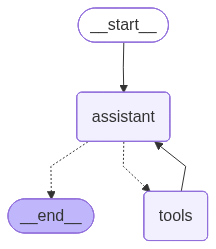

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# 图构建（Graph）
builder = StateGraph(MessagesState)

# 定义节点：实际执行工作的节点
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 定义边：决定控制流如何流转
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # 若 assistant 的最新消息是工具调用 -> tools_condition 路由到 tools
    # 若 assistant 的最新消息不是工具调用 -> tools_condition 路由到 END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# 展示图结构
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_V0qXU0uQqi27StQqwiEAkHke)
 Call ID: call_V0qXU0uQqi27StQqwiEAkHke
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0ZZ2yKpj9PvD9CybGelpyPIa)
 Call ID: call_0ZZ2yKpj9PvD9CybGelpyPIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_RpjZyTStHN5amkMXj0G0O6SK)
 Call ID: call_RpjZyTStHN5amkMXj0G0O6SK
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

## LangSmith

你可以在 LangSmith 中查看[执行轨迹（traces）](https://smith.langchain.com/o/7bfa9385-4ac5-468a-a06c-ffd7dbac42ec/projects/p/d0a1a7a3-9644-4271-82cb-ccadc3ab6969?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=66968bd4-8df4-4841-82f5-ec4ab9205a3b&peeked_trace=66968bd4-8df4-4841-82f5-ec4ab9205a3b)，以便调试与分析。

**运行结果截图**
![LangSmith 链路追踪结果](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509101720154.png)